# Распознавание цифр. Точность и полнота. 

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, svm
from sklearn import metrics
from sklearn.datasets import fetch_openml
from keras import models, layers, utils
import os

База данных MNIST из рукописных цифр - один из наиболее известных наборов данных. Мы возьмем множество изображений размером 28x28 и соответствующие им номера с ресурса https://www.openml.org/, используя функцию fetch_openml из sklearn. Поскольку API ещё сырое, возникла проблема с кешированием и пришлось делать его вручную (внизу). 

In [7]:
def load_mnist():
    if not os.path.isfile('mnist_X.npy'):
        X,y = mnist = fetch_openml('mnist_784', cache=False, return_X_y=True)
        np.save('mnist_X',X)
        np.save('mnist_y',y)
    else:
        X = np.load('mnist_X.npy')
        y = np.load('mnist_y.npy')
    
    y = np.array([int(yy) for yy in y]) # метки оказались строковыми, преобразуем эти строки в числа.
    return X,y

In [6]:
X, y = load_mnist()

Всего 70000 цифр, они представлены в виде массивов серых пикселей (числа от 0 до 255) размером 784 (расплющенный 28x28). Набор данных не отсортирован.

In [16]:
print(X.shape, y.shape)
print(y[:10])
print(X[0,::40]) # выведем каждый 40й пиксель

(70000, 784) (70000,)
[5 0 4 1 9 2 1 3 1 4]
[  0.   0.   0.   0. 166.   0. 247.   0. 253.   0.   0.   0.   0. 183.
   0. 253.   0. 212.   0.   0.]


Matplotlib может отображать такие матрицы пикселей, но желательно указать, что нам нужна черно-белая интерпретация через аргумент cmap.

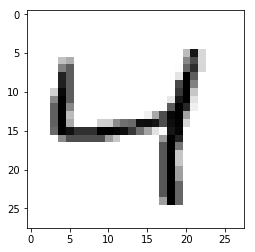

In [20]:
plt.imshow(X[2].reshape(28,28), cmap=plt.cm.gray_r)

В ходе семинара стало понятно, что нормализация изображения в диапазон 0..1 позволяет обеспечить лучшую сходимость некоторых моделей.

In [21]:
X /= 256

Для скорости будем использовать только часть данных. 3000 цифр для тренировки и 500 для проверки.

In [22]:
X_train, y_train = X[:3000], y[:3000]
X_test, y_test = X[3000:3500], y[3000:3500]

В качестве первой модели попробуем логистическую регрессию, которая опирается на линейное разделение данных.

In [23]:
log_r = linear_model.LogisticRegression(verbose=1)
log_r.fit(X_train, y_train)

/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

Пример предсказаний (сверху) и истинных цифр (снизу)

In [25]:
y_pred = log_r.predict(X_test)
print(y_pred[:20])
print(y_test[:20])

[9 0 8 8 1 3 2 5 7 4 1 8 6 3 9 0 0 2 4 1]
[9 0 8 8 1 3 2 5 7 4 7 8 0 3 8 0 0 2 4 1]


Замерим долю правильных ответов (accuracy) в обучающей выборке.

In [29]:
print(metrics.accuracy_score(y_test, y_pred))

0.904


В общем случая, доля правильных ответов не является надежной метрикой для классификаторов, особенно если речь идёт о несбалансированных наборах данных. Например, если один класс встречается в 99% случаев, а другой в 1%, то классификатор, который всегда назначает первый класс, по этой метрики будет иметь 0.99.

Более детальной метрикой является точность (precision) и полнота (recall). Они замеряются отдельно для каждого класса. Введем следующие обозначения: <br>
$TP$ (True Positive) ---  количество экземпляров, которым классификатор корректно назначил этот класс.<br>
$FP$ (False Positive) --- количество экземпляров, которым классификатор ошибочно назначил этот класс.<br>
$TN$ (True Negative) --- количество экземпляров, которым классификатор корректно не назначил этот класс.<br>
$FN$ (False Negative) --- количество экземпляров, которым классификатор ошибочно не назначил этот класс.<br>

Тогда точность равна пропорции правильных назначений класса к общему числу назначений этого класса:
\begin{equation*}
precision = \frac{TP}{TP + FP}
\end{equation*}
Полнота равна пропорции правильных назначений класса к общему числу экземпляров этого класса.
\begin{equation*}
recall = \frac{TP}{TP + FN}
\end{equation*}

Точность и полнота активно используются как метрики в поисковых системах. В этом контексте точность - это пропорция релевантных документов в поисковой выдаче, а полнота - это пропорция релевантных, попавших в выдачу, к общему числу релевантных документов.

Часто их объединяют в F1-меру - среднее гармоническое этих метрик:
\begin{equation*}
F1 = \frac{2 * precision * recall}{precision + recall}
\end{equation*}

In [30]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        47
           1       0.85      0.98      0.91        52
           2       0.90      0.94      0.92        48
           3       0.88      0.88      0.88        51
           4       0.95      0.93      0.94        61
           5       0.84      0.86      0.85        36
           6       0.93      0.95      0.94        44
           7       0.90      0.90      0.90        50
           8       0.90      0.79      0.84        56
           9       0.90      0.85      0.88        55

   micro avg       0.90      0.90      0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.91      0.90      0.90       500



Можно заметить, что цифру 8 обладает наименьшей полнотой (т.е. классификатор достаточно часто ошибочно не идентифицирует эту цифру), а цифра 5 обладает наименьшей точностью (модель часто ошибочно ее назначает).

Матрица ошибок - это матрица, элемент которой $M_{ij}$ равен числу экземпляров класса $i$, которые классификатор пометил как класс $j$. 

In [32]:
print(metrics.confusion_matrix(y_test, y_pred))

[[45  0  0  1  0  0  1  0  0  0]
 [ 0 51  0  0  0  0  0  0  1  0]
 [ 0  0 45  0  1  0  1  0  1  0]
 [ 0  1  1 45  0  2  0  2  0  0]
 [ 0  0  1  0 57  0  1  0  0  2]
 [ 1  3  0  1  0 31  0  0  0  0]
 [ 0  0  0  0  0  0 42  0  2  0]
 [ 0  2  1  0  0  0  0 45  0  2]
 [ 0  2  1  2  2  3  0  1 44  1]
 [ 0  1  1  2  0  1  0  2  1 47]]


В целом, здесь нет сильно выделяющихся значений, максимум цифра 5 была перепутана с цифрой 1 3 раза, также как цифра 8 с цифрой 5.

Отметим, что имея эту матрицу можно вычислить точность и полноту:
\begin{equation*}
precision_i = \frac{M_{ii}}{\sum_j M_{ji}}
\end{equation*}
т.е. пропорция диагонального элемента к сумме $i$-го столбца.
\begin{equation*}
recall_i = \frac{M_{ii}}{\sum_j M_{ij}}
\end{equation*}
т.е. пропорция диагонального элемента к сумме $i$-ой строки.


In [35]:
M = metrics.confusion_matrix(y_test, y_pred)
print("Precision ", np.round(M.diagonal() / M.sum(axis=0), 2))
print("Recall ", np.round(M.diagonal() / M.sum(axis=1), 2))


Precision  [0.98 0.85 0.9  0.88 0.95 0.84 0.93 0.9  0.9  0.9 ]
Recall  [0.96 0.98 0.94 0.88 0.93 0.86 0.95 0.9  0.79 0.85]


Рассмотрим примеры перепутываемых цифр, например, 8, перепутанную с 5.

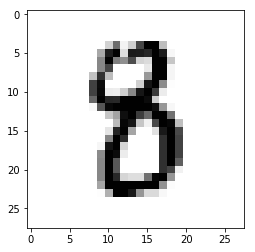

In [36]:
digit = X_test[(y_test == 8) & (y_pred == 5)][0]
plt.imshow(digit.reshape(28,28), cmap=plt.cm.gray_r)

9 c 1

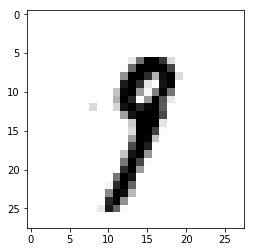

In [37]:
digit = X_test[(y_test == 9) & (y_pred == 1)][0]
plt.imshow(digit.reshape(28,28), cmap=plt.cm.gray_r)

Попробуем также другие классификаторы, в частности SVM с RBF-ядром. В данном случае необходимо искать подходящее значение параметра $\gamma$, которое даст необходимый баланс между обобщаемостью и гибкостью модели (см. лекцию). Туториал будет обновлен под автоматический поиск позднее, но лучшее найденное значение на семинаре было 0.04.

In [38]:
svc = svm.SVC(gamma = 0.04)
# X -= X.mean(axis=0)
svc.fit(X_train, y_train)


y_pred = svc.predict(X_test)

In [39]:
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

0.958
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.98      0.98      0.98        52
           2       0.96      0.98      0.97        48
           3       0.93      0.98      0.95        51
           4       0.94      0.98      0.96        61
           5       0.94      0.94      0.94        36
           6       0.95      0.95      0.95        44
           7       0.98      0.94      0.96        50
           8       0.96      0.95      0.95        56
           9       0.96      0.89      0.92        55

   micro avg       0.96      0.96      0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

[[46  0  0  1  0  0  0  0  0  0]
 [ 0 51  0  0  0  1  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  1  0]
 [ 0  0  1 50  0  0  0  0  0  0]
 [ 0  0  0  0 60  0  1  0  0  0]
 [ 1  1  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  1 42  0  1  0]
 [ 0

Напоследок, натренируем нейронную сеть, используя библиотеку Keras. Данная сеть имеет два скрытых слоя по 300 и 200 элементов и $relu(x) = max(x,0)$ активациями. $softmax$ слой используется для получения распределения вероятностей, также как в мультиномиальной логистической регрессии. keras.utils.to_categorical используется для преобразования y_train в one-hot кодировки (аналогично OneHotEncoder в туториале про pandas).

In [78]:
nn = models.Sequential()
nn.add(layers.Dense(units=300,activation='relu', input_dim=784))
nn.add(layers.Dense(units=200,activation='relu'))

nn.add(layers.Dense(units=10, activation='softmax'))

y_train_oh = utils.to_categorical(y_train, 10)
nn.compile(optimizer='adagrad', loss='categorical_crossentropy')

In [79]:
nn.fit(X_train,y_train_oh,batch_size=64,epochs=40,verbose=2)

Epoch 1/40
 - 1s - loss: 0.7971
Epoch 2/40
 - 0s - loss: 0.2455
Epoch 3/40
 - 0s - loss: 0.1555
Epoch 4/40
 - 0s - loss: 0.1048
Epoch 5/40
 - 0s - loss: 0.0772
Epoch 6/40
 - 0s - loss: 0.0574
Epoch 7/40
 - 0s - loss: 0.0426
Epoch 8/40
 - 0s - loss: 0.0323
Epoch 9/40
 - 0s - loss: 0.0246
Epoch 10/40
 - 0s - loss: 0.0192
Epoch 11/40
 - 0s - loss: 0.0158
Epoch 12/40
 - 0s - loss: 0.0129
Epoch 13/40
 - 0s - loss: 0.0107
Epoch 14/40
 - 0s - loss: 0.0091
Epoch 15/40
 - 0s - loss: 0.0078
Epoch 16/40
 - 0s - loss: 0.0068
Epoch 17/40
 - 0s - loss: 0.0061
Epoch 18/40
 - 0s - loss: 0.0054
Epoch 19/40
 - 0s - loss: 0.0049
Epoch 20/40
 - 0s - loss: 0.0045
Epoch 21/40
 - 0s - loss: 0.0040
Epoch 22/40
 - 0s - loss: 0.0037
Epoch 23/40
 - 0s - loss: 0.0034
Epoch 24/40
 - 0s - loss: 0.0032
Epoch 25/40
 - 0s - loss: 0.0030
Epoch 26/40
 - 0s - loss: 0.0028
Epoch 27/40
 - 0s - loss: 0.0026
Epoch 28/40
 - 0s - loss: 0.0024
Epoch 29/40
 - 0s - loss: 0.0023
Epoch 30/40
 - 0s - loss: 0.0022
Epoch 31/40
 - 0s -

In [80]:
y_pred = nn.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(y_pred)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

[9 0 8 8 1 3 2 5 7 4 8 8 0 3 8 0 0 2 4 1 9 0 9 2 0 5 4 3 8 8 6 5 8 3 5 0 6
 4 4 4 8 1 2 6 9 1 6 3 3 0 6 3 4 6 2 9 4 3 6 7 7 4 5 7 2 1 8 0 1 9 4 4 4 8
 4 3 9 2 2 7 1 7 8 9 9 5 8 7 4 6 9 4 4 8 9 5 6 6 6 9 4 4 2 1 9 2 0 0 3 6 4
 1 2 1 8 6 7 4 5 8 1 9 1 6 3 4 5 6 0 5 1 0 1 2 8 0 6 5 4 6 7 5 2 0 8 1 9 2
 8 1 3 7 8 8 8 1 2 4 8 3 0 2 7 8 9 2 2 7 8 9 5 3 6 9 3 0 2 1 3 2 5 3 4 4 4
 5 9 6 5 7 9 8 3 9 4 0 8 1 0 2 2 3 9 4 0 5 7 6 2 7 7 8 1 0 7 3 3 4 4 5 3 6
 4 7 2 8 1 9 7 6 1 0 9 3 1 4 7 1 9 4 4 0 2 8 2 6 7 0 0 7 7 8 9 7 8 7 9 9 3
 0 4 4 0 9 3 9 5 7 5 0 7 5 1 6 2 1 7 9 4 8 4 8 7 7 9 5 0 6 6 1 9 3 9 8 6 1
 9 6 7 8 2 5 9 9 2 2 1 2 2 0 9 9 4 2 8 4 9 7 3 3 3 1 9 3 7 6 5 6 0 2 6 1 3
 2 4 6 8 0 8 2 4 2 2 7 1 1 9 3 9 7 4 4 4 8 8 9 5 2 3 9 4 5 2 6 6 8 6 3 7 0
 4 9 7 1 3 1 0 0 5 1 1 4 9 3 5 5 3 6 4 9 2 0 8 1 1 2 0 3 9 4 3 5 3 6 3 7 1
 8 7 0 0 1 1 2 9 3 5 4 1 5 8 6 3 7 3 8 7 1 7 0 1 1 1 5 0 3 4 4 8 4 1 0 7 0
 2 6 8 9 7 6 4 6 3 5 6 4 1 4 4 4 3 0 3 7 1 9 3 5 1 7 2 3 3 1 6 4 8 4 1 0 8
 9 8 9 9 6 2 1 1 8 0 3 0 